In [1]:
#######################################################################################
# Read Me Section:
## Name:
# Kaylen Smith Darnbrook
# Student ID:
# 2135667
# Course:
# M.S.c Machine Learning and Artificial Intelligence
# Module:
## FaceGeneration and Analysis:
## Description: 
# This module is responsible for creating the experimentation and creation of
# pipeline for the generation of faces using the Generative Accumulation Of Photons.
# The module will also be responsible for the analysis of the faces generated.
#####################################################################################

In [2]:
# Import Relevant Libraries:

# Import modules for system managment, io and file management 
import os 
import sys
import time 
import random

# Import modules for data manipulation and analysis
import numpy as np
import pandas as pd
import scipy as sp

# Import modules for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook")
import plotly.express as px
from PIL import Image
import cv2
from albumentations.core.transforms_interface import ImageOnlyTransform

# Import modules for Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
torch.set_float32_matmul_precision('medium')
from torchviz import make_dot
from tqdm import tqdm

# Pytorch Lightning Modules:
import pytorch_lightning as pL
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import LearningRateMonitor

# Import modules for model selection and evaluation.
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.metrics import peak_signal_noise_ratio as psnr

# Import the DataLoader
#from BinomDataset4 import FacesDataset
from PoissonDataset6 import FacesDataset
from PoissonValidator import ValidationSetGenerator

# Import CustomModules
from OriginalGAPUNet import UNet
from GAPAttentionUNetArchitecture import AttentionUNet
from inference2 import sample_image_3

# Hugging face applications
from huggingface_hub import notebook_login
from dataclasses import dataclass
from diffusers import UNet2DModel
from accelerate import Accelerator
from accelerate import notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from huggingface_hub import create_repo, upload_folder

# Visualisation Software
import matplotlib.image as mpimg
import time
import numpy as np

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [3]:
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "red"
plt.rc("text", usetex = False)
plt.rc("font", family = "Times New Roman")
plt.rcParams["axes.grid"] = False

In [4]:
## Configuration
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
GREYSCALE = False

# Set the path to the data
root_path = r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\Datasets\ffhq256"
out_dir =r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\ValidationFIle"
Batch_Size = 32
load_pretained = False
NUM_Features = 128 * 128
max_epochs = 20
learning_rate = 1e-3
patience = 10
minpsnr = -40
maxpsnr = 40

Device: cuda


In [5]:
Steps = 10
Spacing = (maxpsnr - minpsnr) // Steps
PSNR_Ranges = [(i, j) for i, j in zip(range(minpsnr, maxpsnr, Spacing), range(minpsnr + Spacing, maxpsnr + Spacing, Spacing))]
print(PSNR_Ranges)

[(-40, -32), (-32, -24), (-24, -16), (-16, -8), (-8, 0), (0, 8), (8, 16), (16, 24), (24, 32), (32, 40)]


In [6]:
def PSNR(original, transformed, maximum):
    mse = np.mean((original-transformed)**2)
    if mse == 0:
        return 100
    max_pixel_value = maximum
    psnr = 20 * np.log10(max_pixel_value/np.sqrt(mse))
    return psnr

def SSIM(original, transformed):
    return sp.signal.ssim(original, transformed, multichannel=True)

def Psuedo_PSNR(original, transformed, image_size, maximum):
    mse = np.mean((original-transformed)**2)
    intensity = transformed/image_size
    if intensity == 0 or mse == 0:
        return 100
    max_pixel = maximum
    signal_score = intensity * image_size * original
    psnr = 20 * np.log(signal_score/np.sqrt(mse))
    return psnr

def Estimated_Psuedo_PSNR(transformed, image_size):
    intensity = transformed/image_size
    return 10 * np.log(intensity)

In [7]:
def plot_random_person(images, sample = 9):
    random_image_indexes=random.sample(list(range(images.shape[0])),sample)
    
    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt, sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize=(20,20))
    for index, values in enumerate(random_image_indexes):
        plt.subplot(Length,width,index+1)
        image = (images[values] - images[values].min())/(images[values].max() - images[values].min())
        image*=255.0
        image = image.astype(np.uint8)
        plt.imshow(image)
        plt.title(f'Person_id: {random_image_indexes[index]}\nShape: {images.shape}')
    return fig

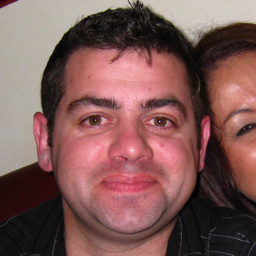

In [8]:
Image_Paths = [os.path.join(root_path, img) for img in os.listdir(root_path)]
Image_Paths 
Image.open(os.path.join(root_path, Image_Paths[16]))

In [9]:
Directory = [path for path in os.listdir(root_path)]
rng = np.random.default_rng(20)
indices = rng.permutation(len(Directory))
split_index = int(len(Directory) * 0.8)
train_indices = indices[:split_index]
val_indices = indices[split_index:]
train_indices.shape, val_indices.shape

((56000,), (14000,))

In [10]:
Train_Paths = [Directory[index] for index in train_indices]
Val_Paths = [Directory[index] for index in val_indices]
Paths = Train_Paths.copy()
Paths.extend(Val_Paths)
np.shape(Train_Paths), np.shape(Val_Paths), np.shape(Paths)

((56000,), (14000,), (70000,))

In [11]:
Pre_Train_Dataset = FacesDataset(root_dir = root_path, names = Train_Paths, minPSNR= PSNR_Ranges[-10][0] , targetPSNR = PSNR_Ranges[-10][1], augment = True, grayscale= GREYSCALE, virtSize = 512*Batch_Size, amplification_factor = 1e3)
Pre_Val_Dataset = FacesDataset(root_dir = root_path, names = Val_Paths, minPSNR= PSNR_Ranges[-10][0], targetPSNR = PSNR_Ranges[-10][1], augment = False, grayscale= GREYSCALE, virtSize = 128*Batch_Size, amplification_factor = 1e3)
Pre_Train_Loader = DataLoader(Pre_Train_Dataset, batch_size = Batch_Size, shuffle = True)
Pre_Validation_Loader = DataLoader(Pre_Val_Dataset, batch_size = Batch_Size, shuffle = False)
Pre_Train_Dataset.__len__(), Pre_Val_Dataset.__len__()

(16384, 4096)

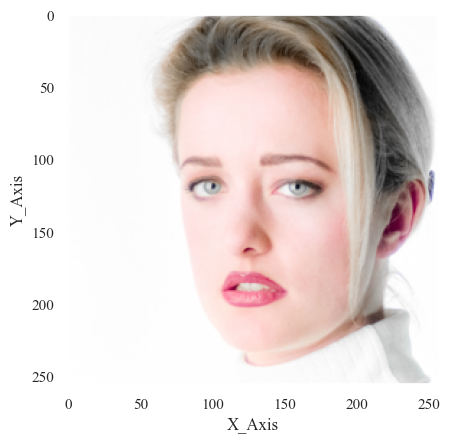

In [12]:
# Presents the untransformed image:
Pre_Train_Dataset.show_image(155)

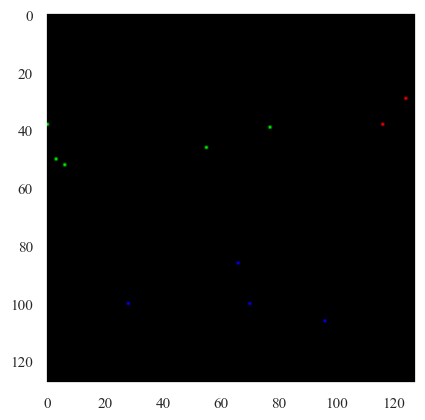

PSNR: -36.93708801269531
True PSNR 2.8365763209680903


In [13]:
ImageNoise, psnr_map, image_target = Pre_Train_Dataset.__getitem__(155)
ImageNoise = (ImageNoise - ImageNoise.min())/(ImageNoise.max() - ImageNoise.min())
Psnr_Noise = psnr(image_target.detach().cpu().numpy().astype(np.uint8)*255, ImageNoise.detach().cpu().numpy().astype(np.uint8)*255)
plt.imshow(ImageNoise.detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)*255)
plt.show()
print(f"PSNR: {psnr_map.min().detach().cpu().numpy()}")
print(f"True PSNR {Psnr_Noise}")

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


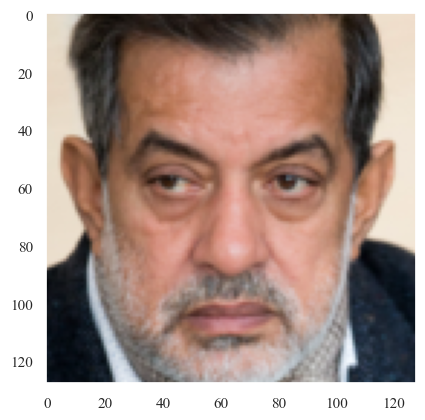

PSNR_Target: 0.0
True PSNR inf


In [14]:
target = image_target.detach().cpu().numpy().transpose(1,2,0)
target = (target - target.min())/(target.max() - target.min())
plt.imshow(target, vmin = 0, vmax = target.max())
Psnr_Target = np.log10(image_target.mean().item()+ 1e-50) *10
Psnr_Target = max(-40, Psnr_Target)
Psnr_Image = psnr(image_target.detach().cpu().numpy().astype(np.uint8)*255, image_target.detach().cpu().numpy().astype(np.uint8)*255)
plt.show()
print(f"PSNR_Target: {Psnr_Target}")
print(f"True PSNR {Psnr_Image}")

In [15]:
out_dir

"C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle"

In [16]:
PSNR_Ranges[-1][1]

40

In [17]:
FaceValidators = [ValidationSetGenerator(root_dir= root_path, out_dir=out_dir, names = Paths, minPSNR= PSNR_Ranges[i][0], targetPSNR = PSNR_Ranges[i][1], augment= True, sample_size = 100, grayscale= GREYSCALE, amplification_factor= 1e2) for i in range(len(PSNR_Ranges))]
FaceValidators[0].out_dir

"C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle"

torch.Size([3, 128, 128])


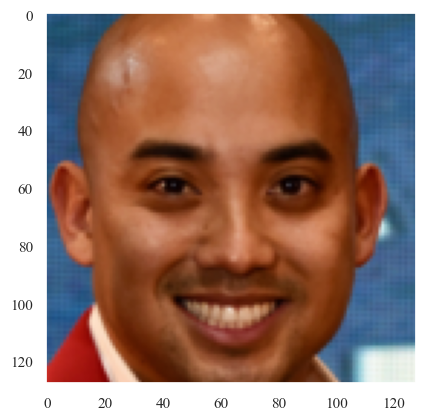

In [18]:
img, psnr_img, target = FaceValidators[0].__GenerateNoisyImage__(100, -20)
print(img.shape)
target = ((target - target.min())/(target.max() - target.min())).detach().cpu().numpy().transpose(1,2,0)*255.0
target = target.astype(np.uint8)
plt.imshow(target)
plt.show()

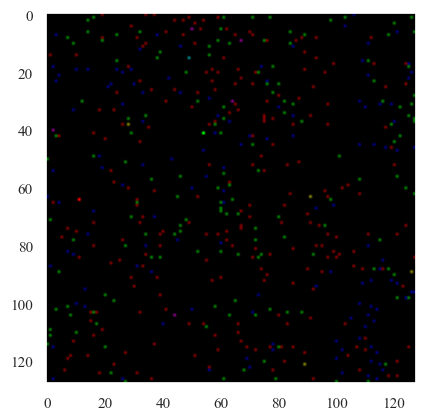

In [19]:
img = ((img - img.min())/(img.max() - img.min())).detach().cpu().numpy().transpose(1,2,0)*255.0
img = img.astype(np.uint8)
plt.imshow(img)

In [20]:
str(PSNR_Ranges[1][0]) + str(PSNR_Ranges[1][1])

'-32-24'

In [21]:
Noisy_Images_Paths = []
Psnr_Maps_Paths = []
Image_Targets_Paths = []
for index in range(len(PSNR_Ranges)):
    psnr_label = str(PSNR_Ranges[index][0]) + str(PSNR_Ranges[index][1])
    print(f"Generating Validation Data for {index} Val_Dataset at psnr range {psnr_label}")
    FaceValidator = FaceValidators[index]
    Noisy_Images_Path, Psnr_Maps_Path, Image_Targets_Path = FaceValidator.Generate_Noisy_Faces(psnr_label)
    Noisy_Images_Paths.append(Noisy_Images_Path)
    Psnr_Maps_Paths.append(Psnr_Maps_Path)
    Image_Targets_Paths.append(Image_Targets_Path)
len(Noisy_Images_Paths), len(Psnr_Maps_Paths), len(Image_Targets_Paths)

Generating Validation Data for 0 Val_Dataset at psnr range -40-32
Generating Validation Data for 1 Val_Dataset at psnr range -32-24
Generating Validation Data for 2 Val_Dataset at psnr range -24-16
Generating Validation Data for 3 Val_Dataset at psnr range -16-8
Generating Validation Data for 4 Val_Dataset at psnr range -80
Generating Validation Data for 5 Val_Dataset at psnr range 08
Generating Validation Data for 6 Val_Dataset at psnr range 816
Generating Validation Data for 7 Val_Dataset at psnr range 1624
Generating Validation Data for 8 Val_Dataset at psnr range 2432
Generating Validation Data for 9 Val_Dataset at psnr range 3240


(10, 10, 10)

In [22]:
Image_Targets_Paths

["C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\-40-32IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\-32-24IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\-24-16IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\-16-8IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\-80IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\08IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\816IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\1624IT.pth",
 "C:\\Users\\kdarn\\OneDrive\\Documents\\Life's Portfolio\\Projects\\GAPGalaxies\\ValidationFIle\\2432IT.pth"

In [23]:
Validation_Noisy_Images = {}
Validation_Psnr_Maps = {}
Validation_Target_Images = {}
for index in range(len(PSNR_Ranges)):
    psnr_label = str(PSNR_Ranges[index][0]) + str(PSNR_Ranges[index][1])
    print(f"Loading Validation Data for {index} Val_Dataset at psnr range {psnr_label}")
    FaceValidator = FaceValidators[index]
    File_Path_NI = Noisy_Images_Paths[index]
    File_Path_PSM = Psnr_Maps_Paths[index]
    File_Path_TI = Image_Targets_Paths[index]
    Noisy_Images, Psnr_Maps, Target_Images = FaceValidator.Load_Noisy_Faces(File_Path_NI, File_Path_PSM, File_Path_TI, device=device)
    Validation_Noisy_Images[psnr_label] = Noisy_Images
    Validation_Psnr_Maps[psnr_label] = Psnr_Maps
    Validation_Target_Images[psnr_label] = Target_Images
len(Validation_Noisy_Images), len(Validation_Psnr_Maps), len(Validation_Target_Images)

Loading Validation Data for 0 Val_Dataset at psnr range -40-32
Loading Validation Data for 1 Val_Dataset at psnr range -32-24
Loading Validation Data for 2 Val_Dataset at psnr range -24-16
Loading Validation Data for 3 Val_Dataset at psnr range -16-8
Loading Validation Data for 4 Val_Dataset at psnr range -80
Loading Validation Data for 5 Val_Dataset at psnr range 08
Loading Validation Data for 6 Val_Dataset at psnr range 816
Loading Validation Data for 7 Val_Dataset at psnr range 1624
Loading Validation Data for 8 Val_Dataset at psnr range 2432
Loading Validation Data for 9 Val_Dataset at psnr range 3240


(10, 10, 10)

In [24]:
with open(r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\Validation_File_PathNames\NoisyImageNames.txt", "w+") as File:
    for name in Noisy_Images_Paths:
        File.write(name)
        File.write("\n")
with open(r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\Validation_File_PathNames\Psnr_MapNames.txt", "w+") as File:
    for name in Psnr_Maps_Paths:
        File.write(name)
        File.write("\n")
with open(r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\Validation_File_PathNames\TargetImageNames.txt", "w+") as File:
    for name in Image_Targets_Paths:
        File.write(name)
        File.write("\n")

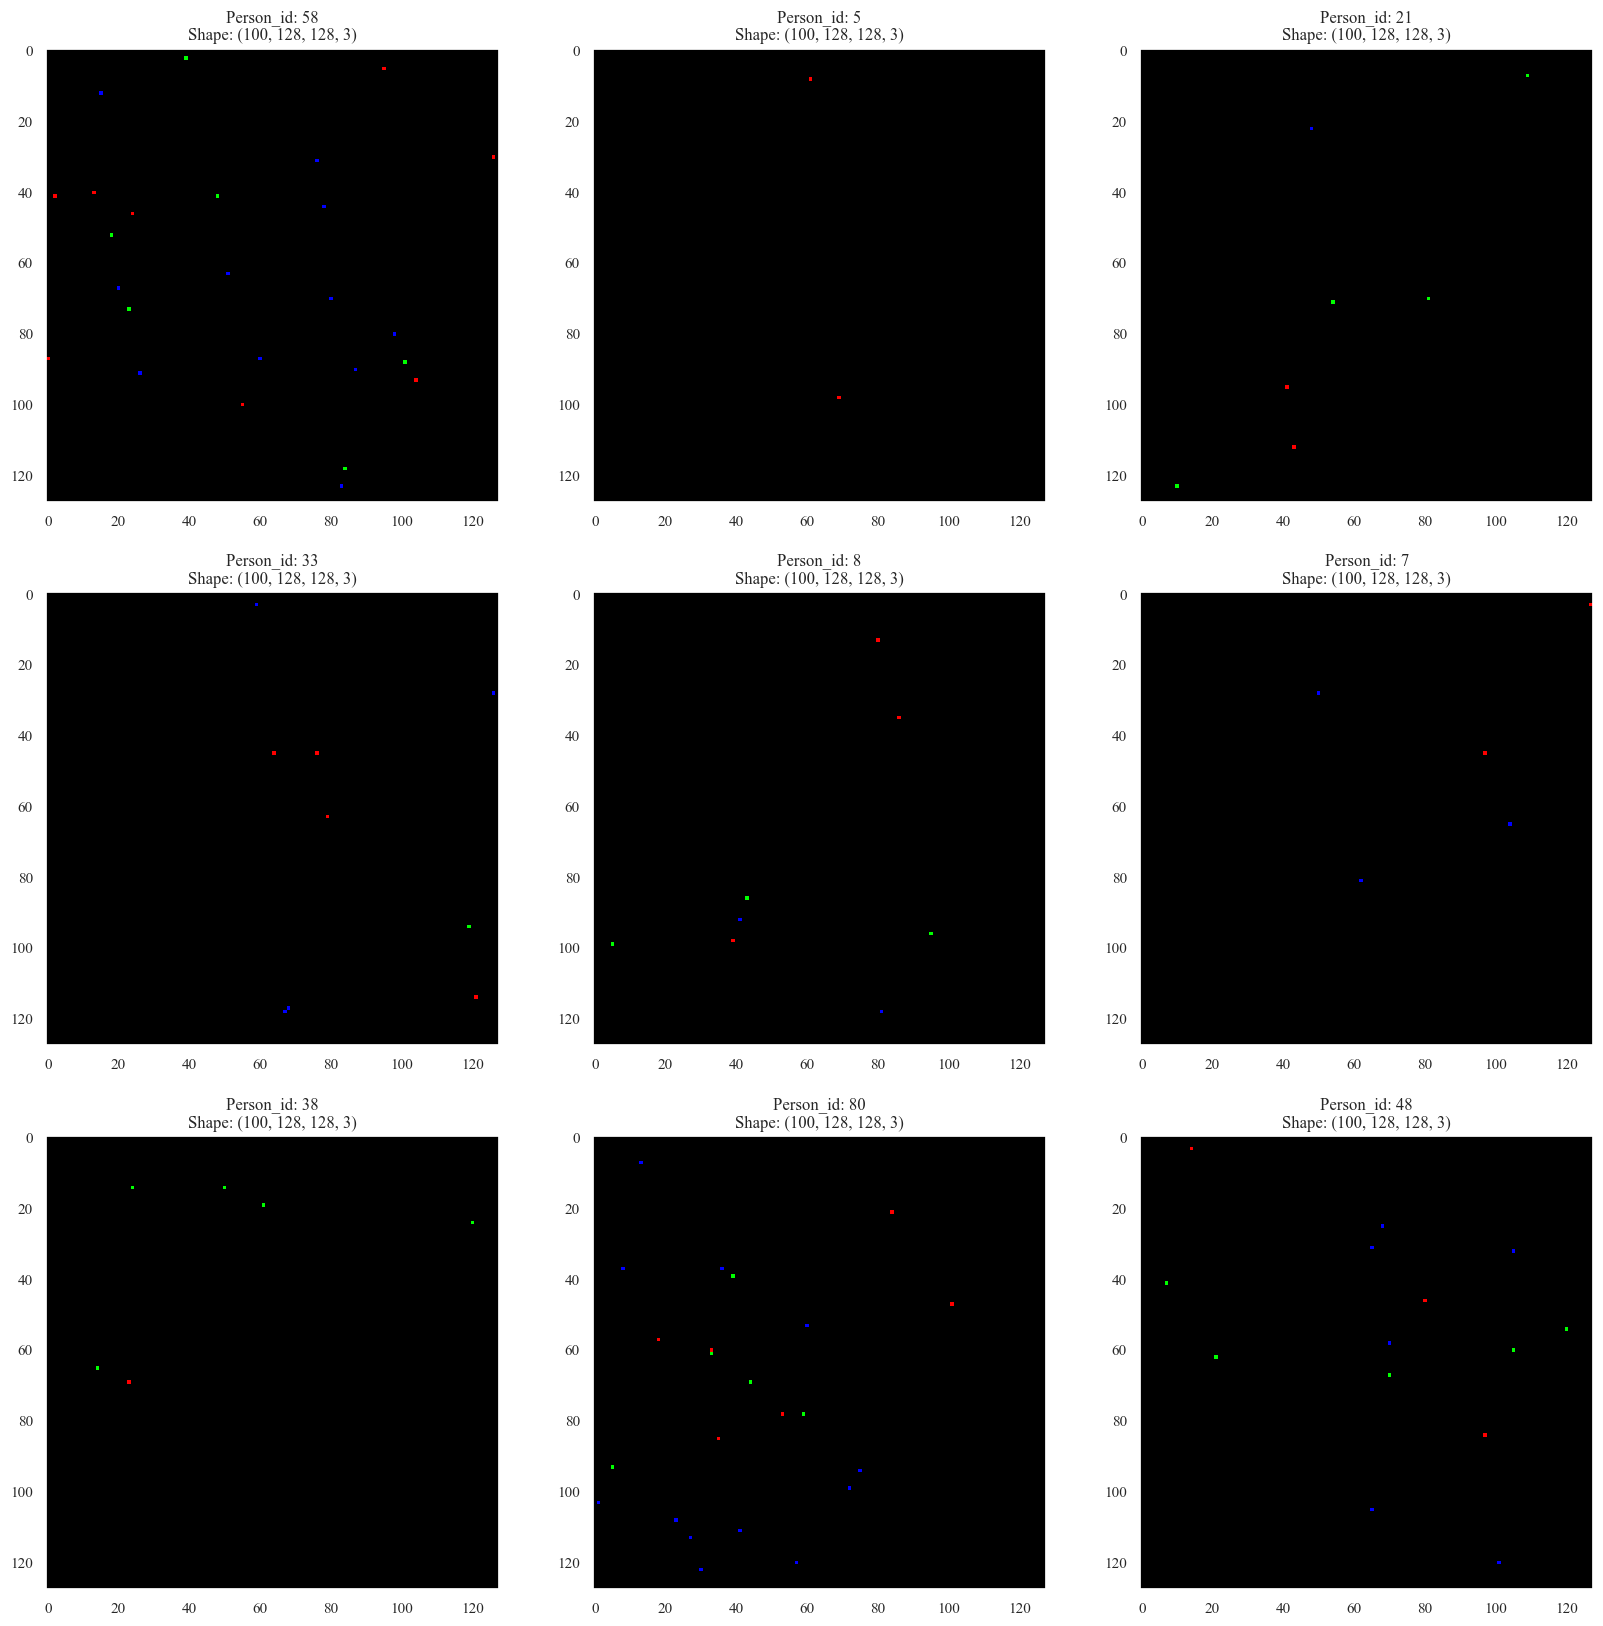

In [25]:
Figure_1 = plot_random_person(Validation_Noisy_Images["-40-32"].detach().cpu().numpy().transpose(0,2,3,1), 9)

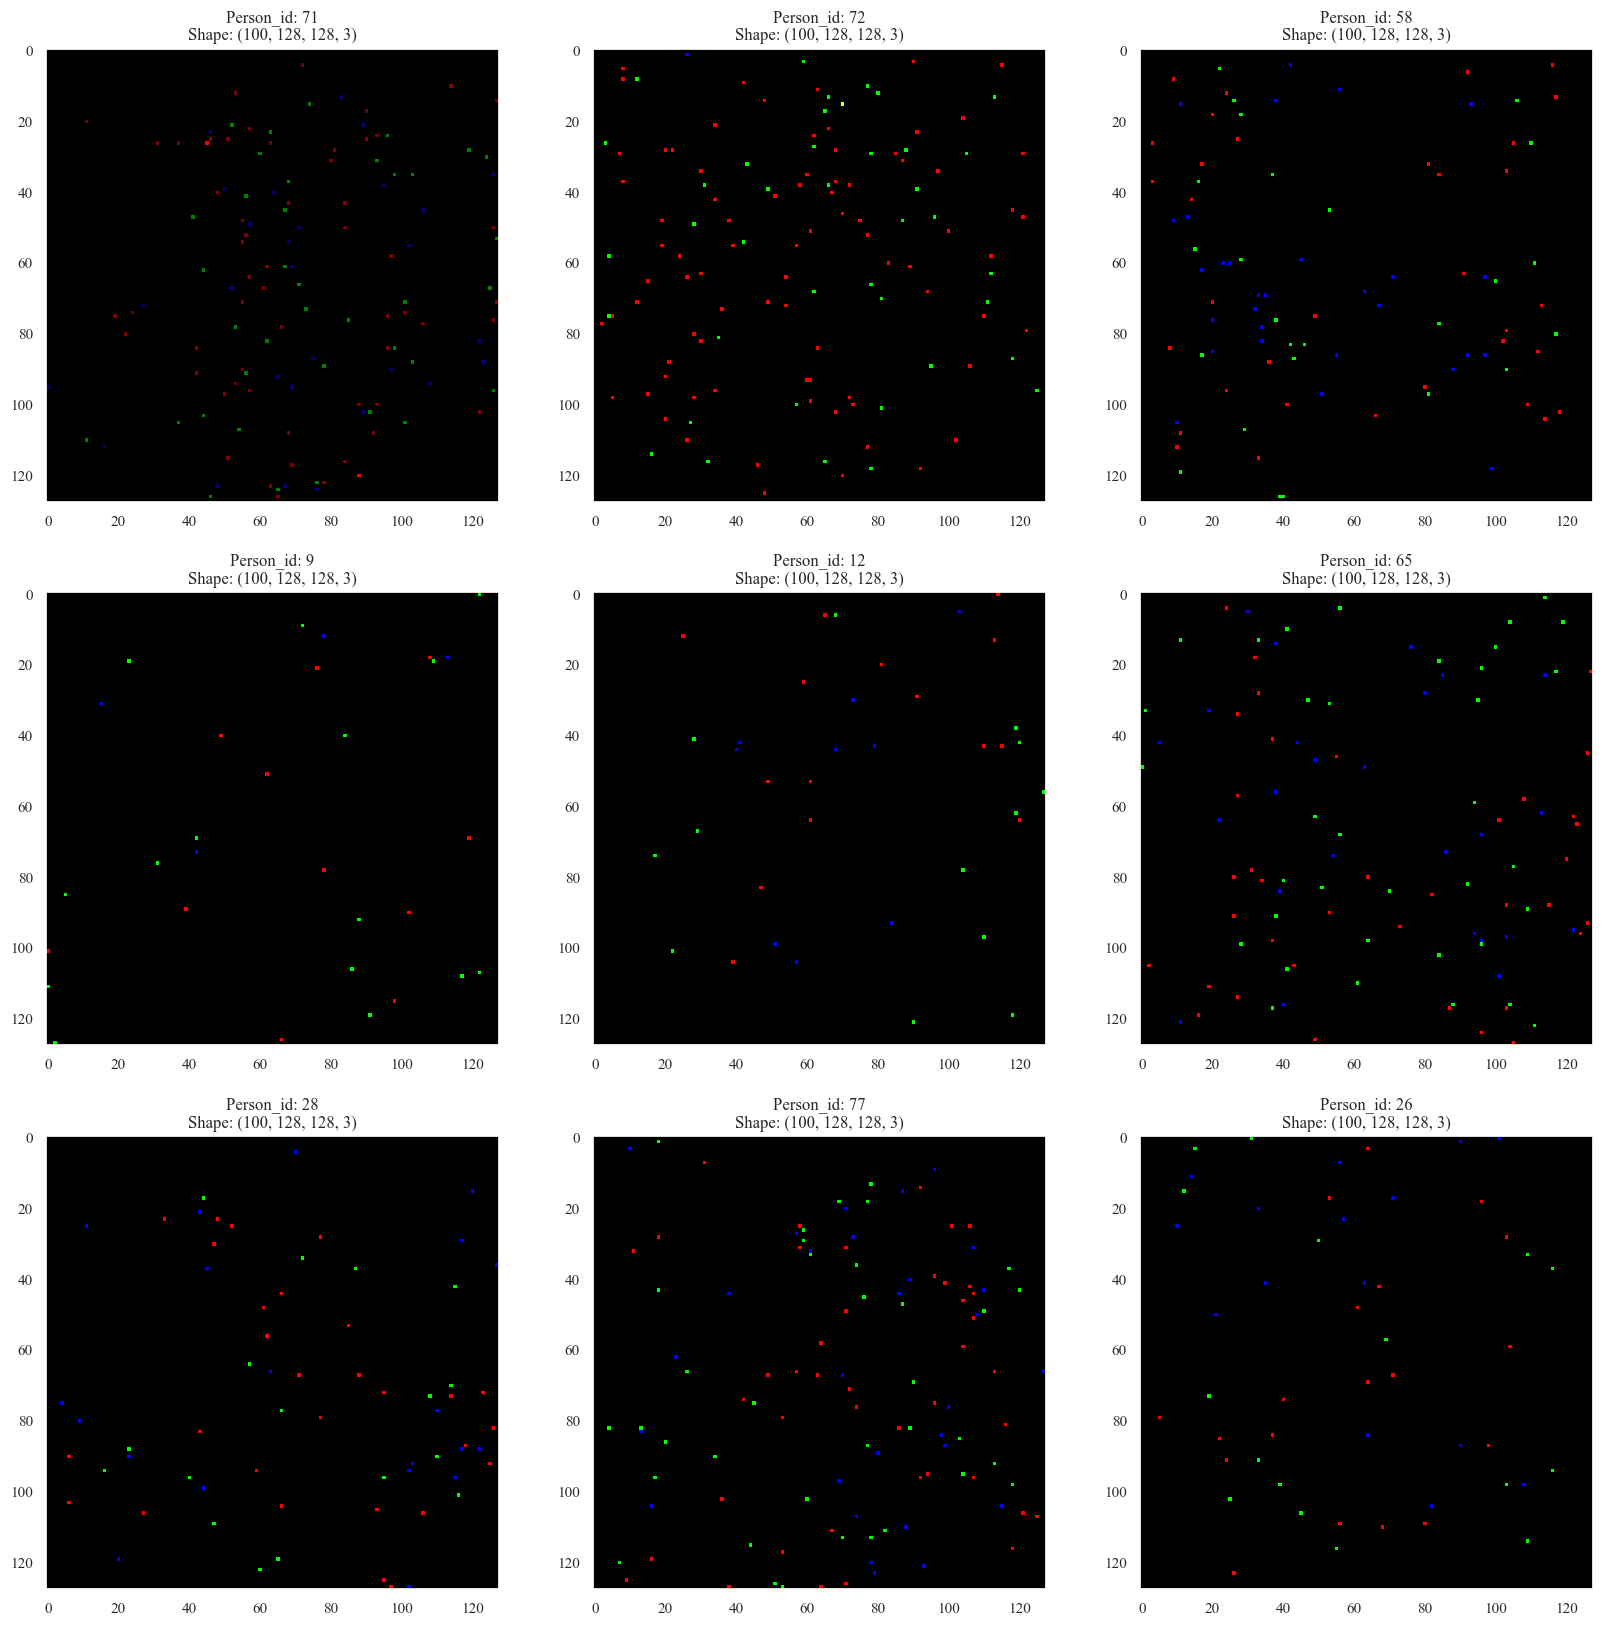

In [26]:
Figure_2 = plot_random_person(Validation_Noisy_Images["-32-24"].detach().cpu().numpy().transpose(0,2,3,1), 9)

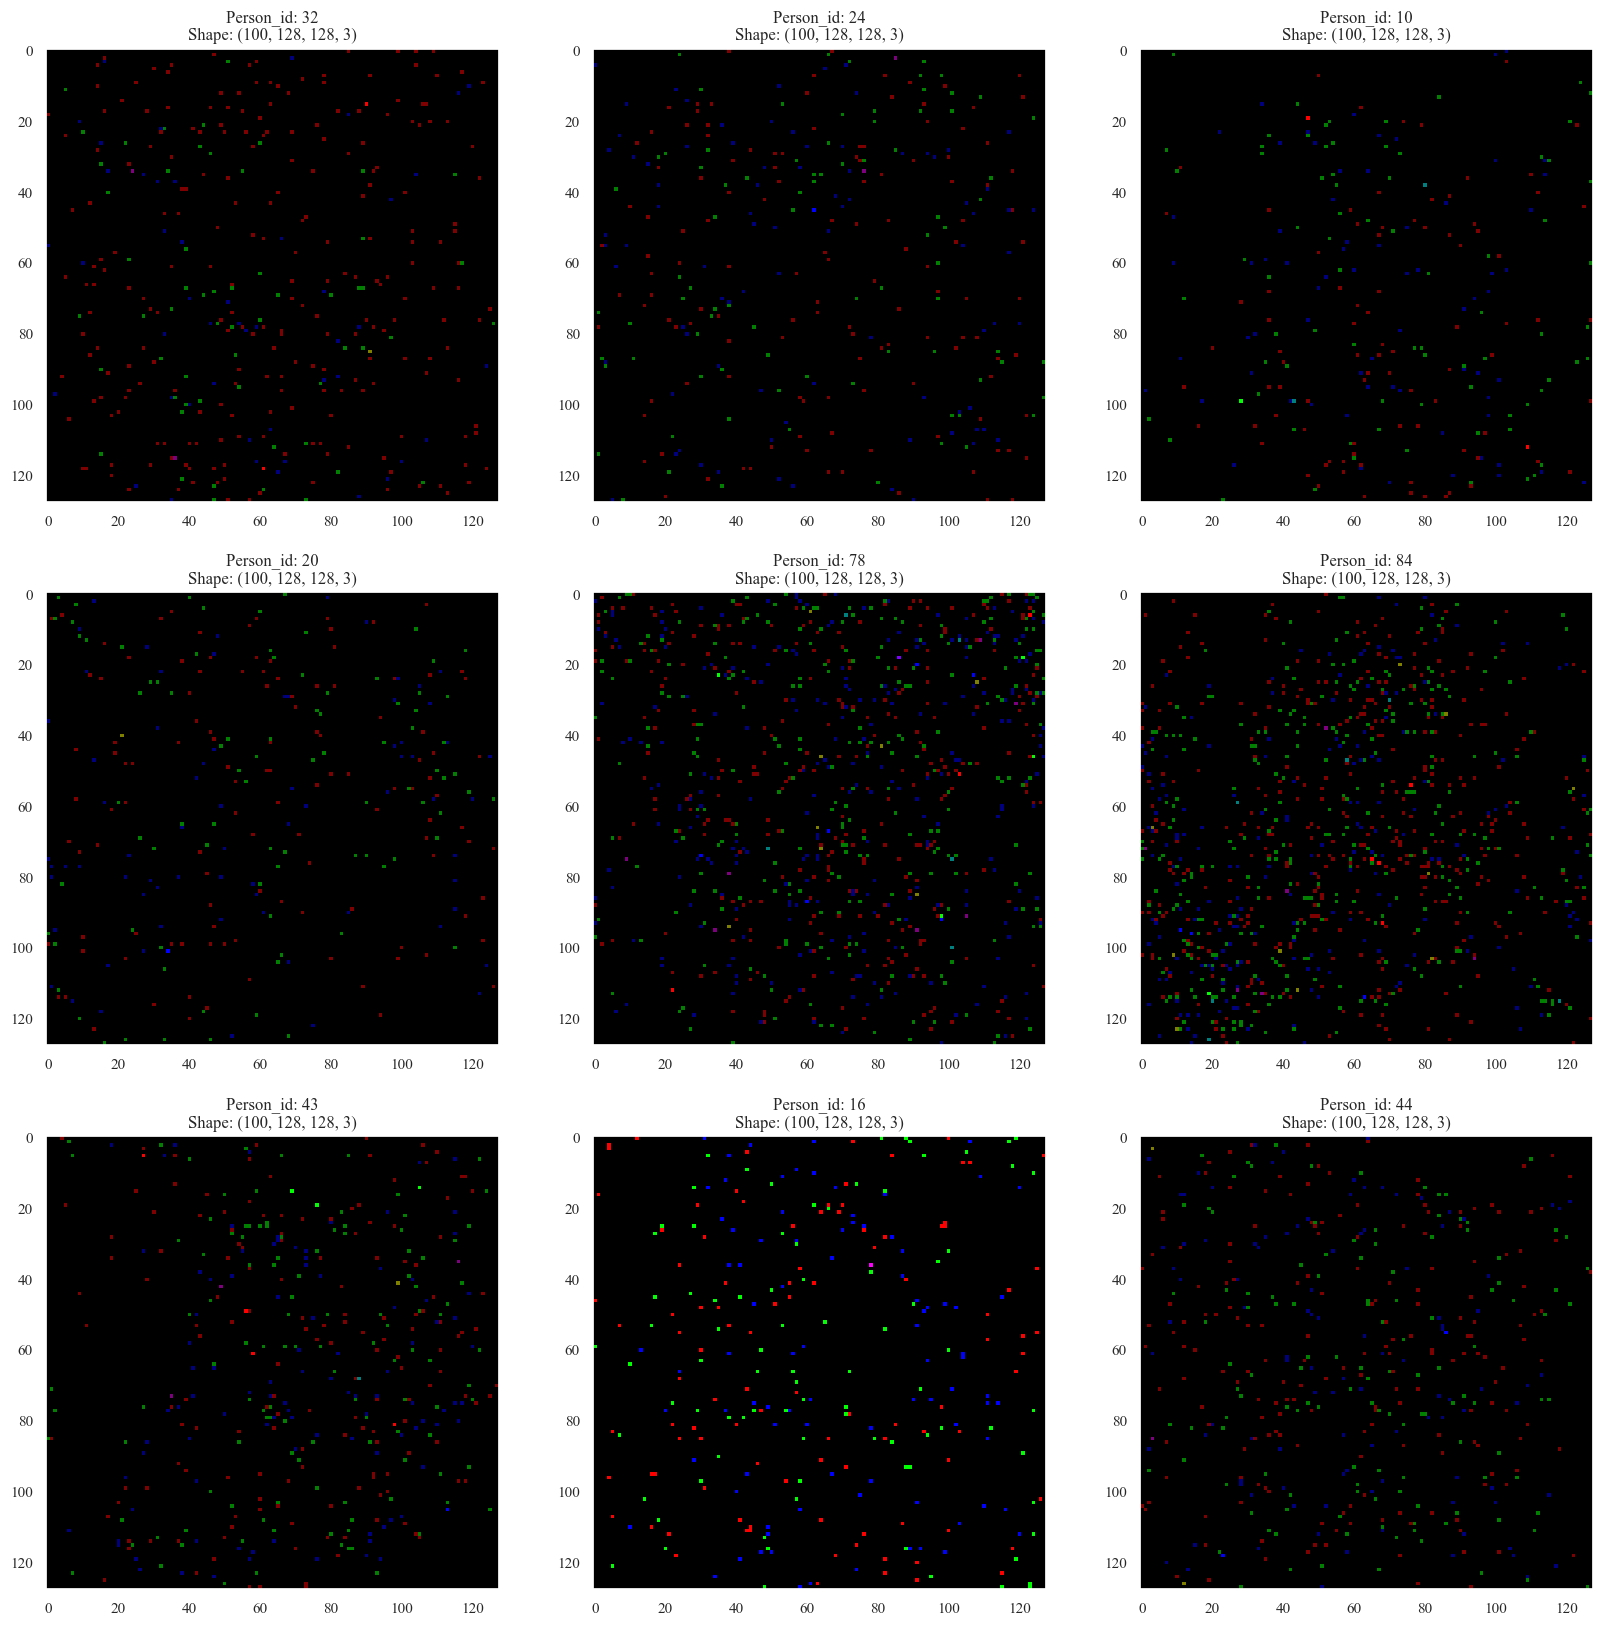

In [27]:
Figure_3 = plot_random_person(Validation_Noisy_Images["-24-16"].detach().cpu().numpy().transpose(0,2,3,1), 9)

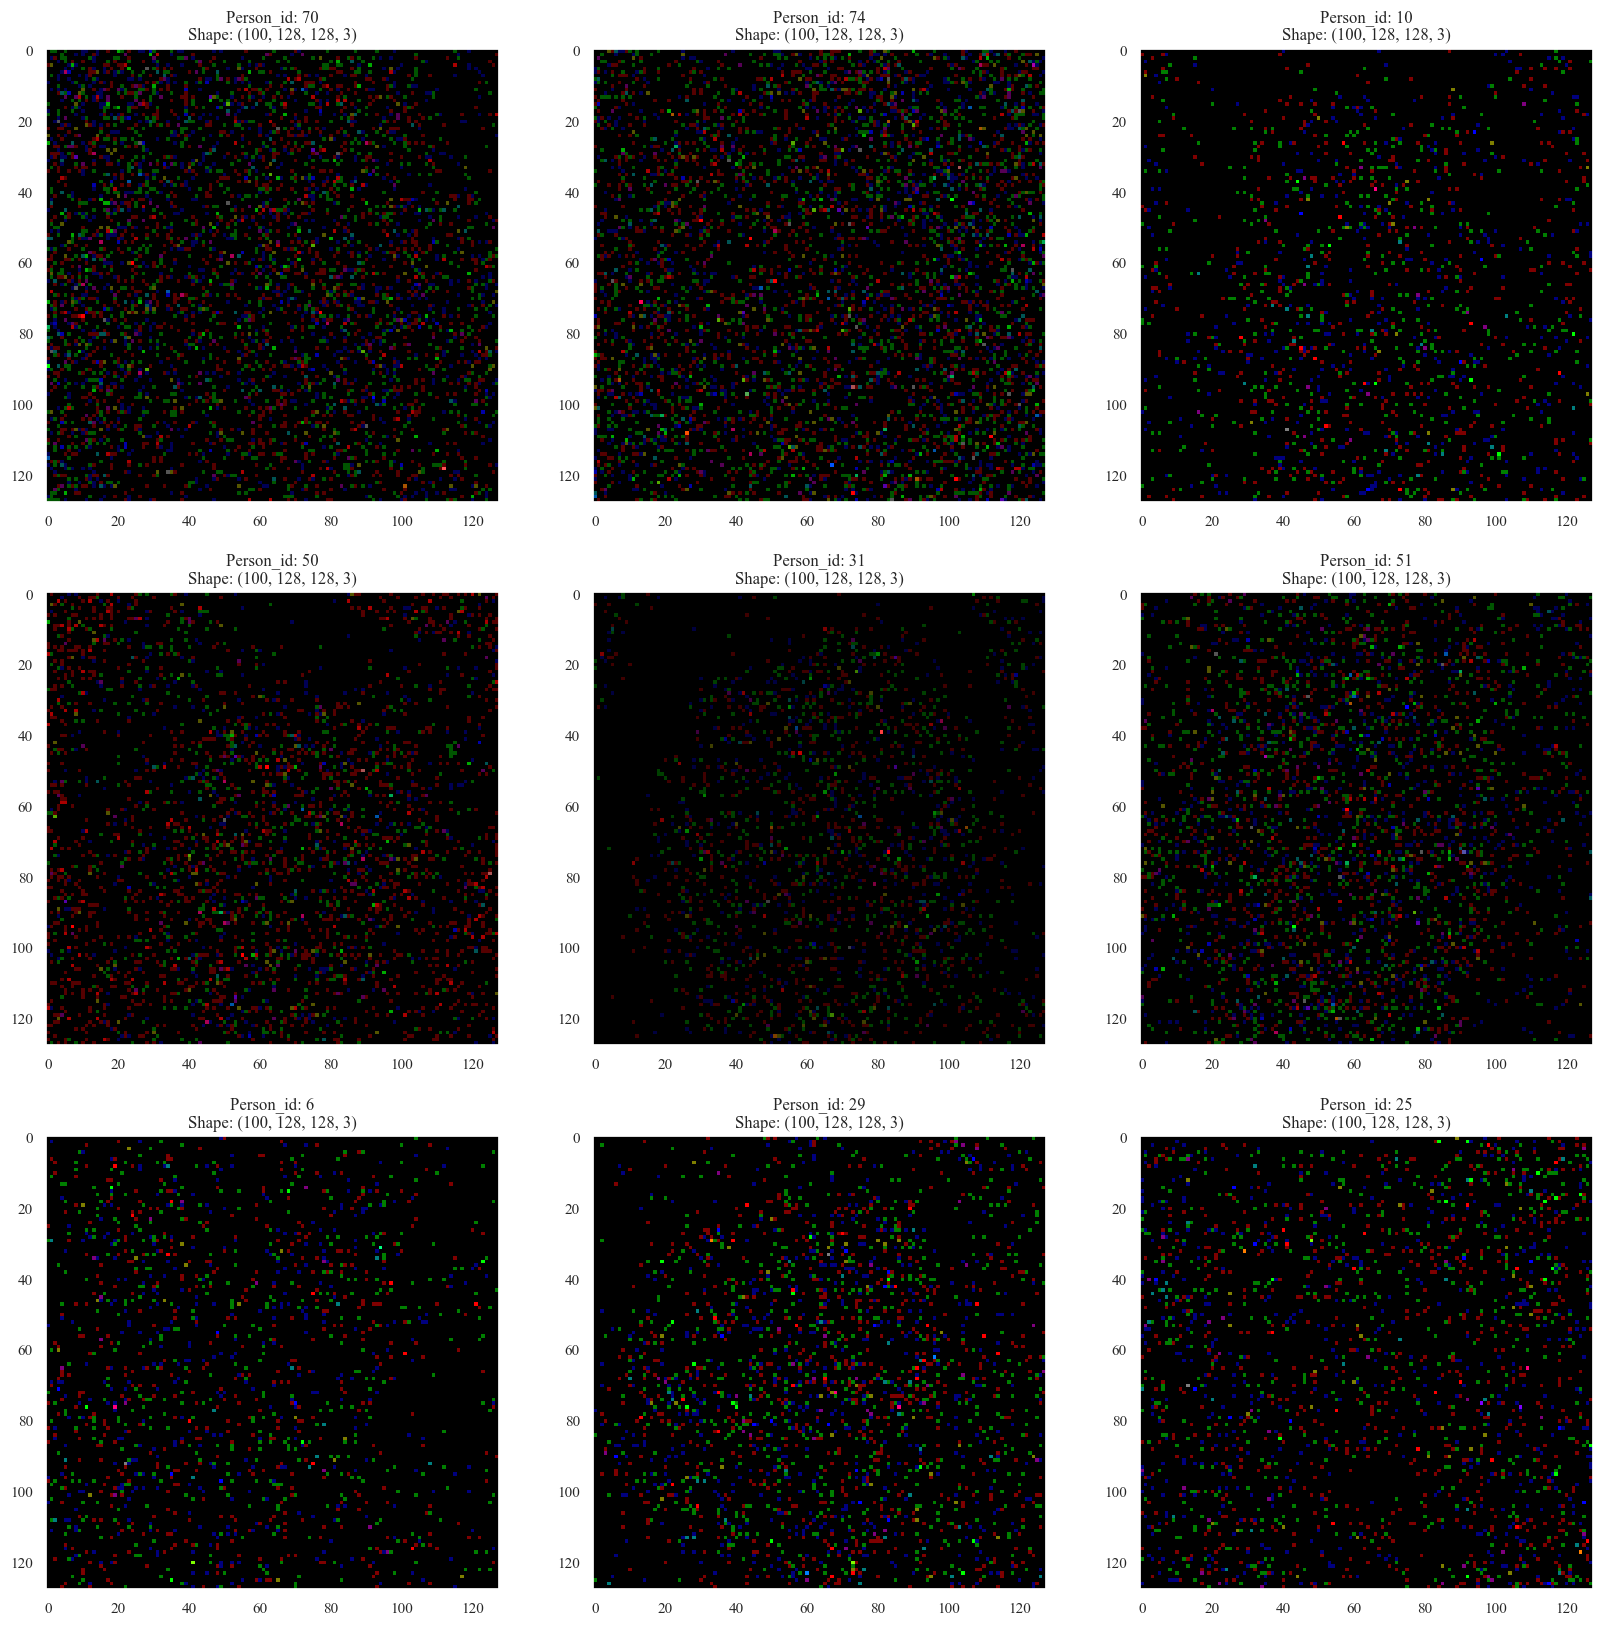

In [28]:
Figure_4 = plot_random_person(Validation_Noisy_Images["-16-8"].detach().cpu().numpy().transpose(0,2,3,1), 9)

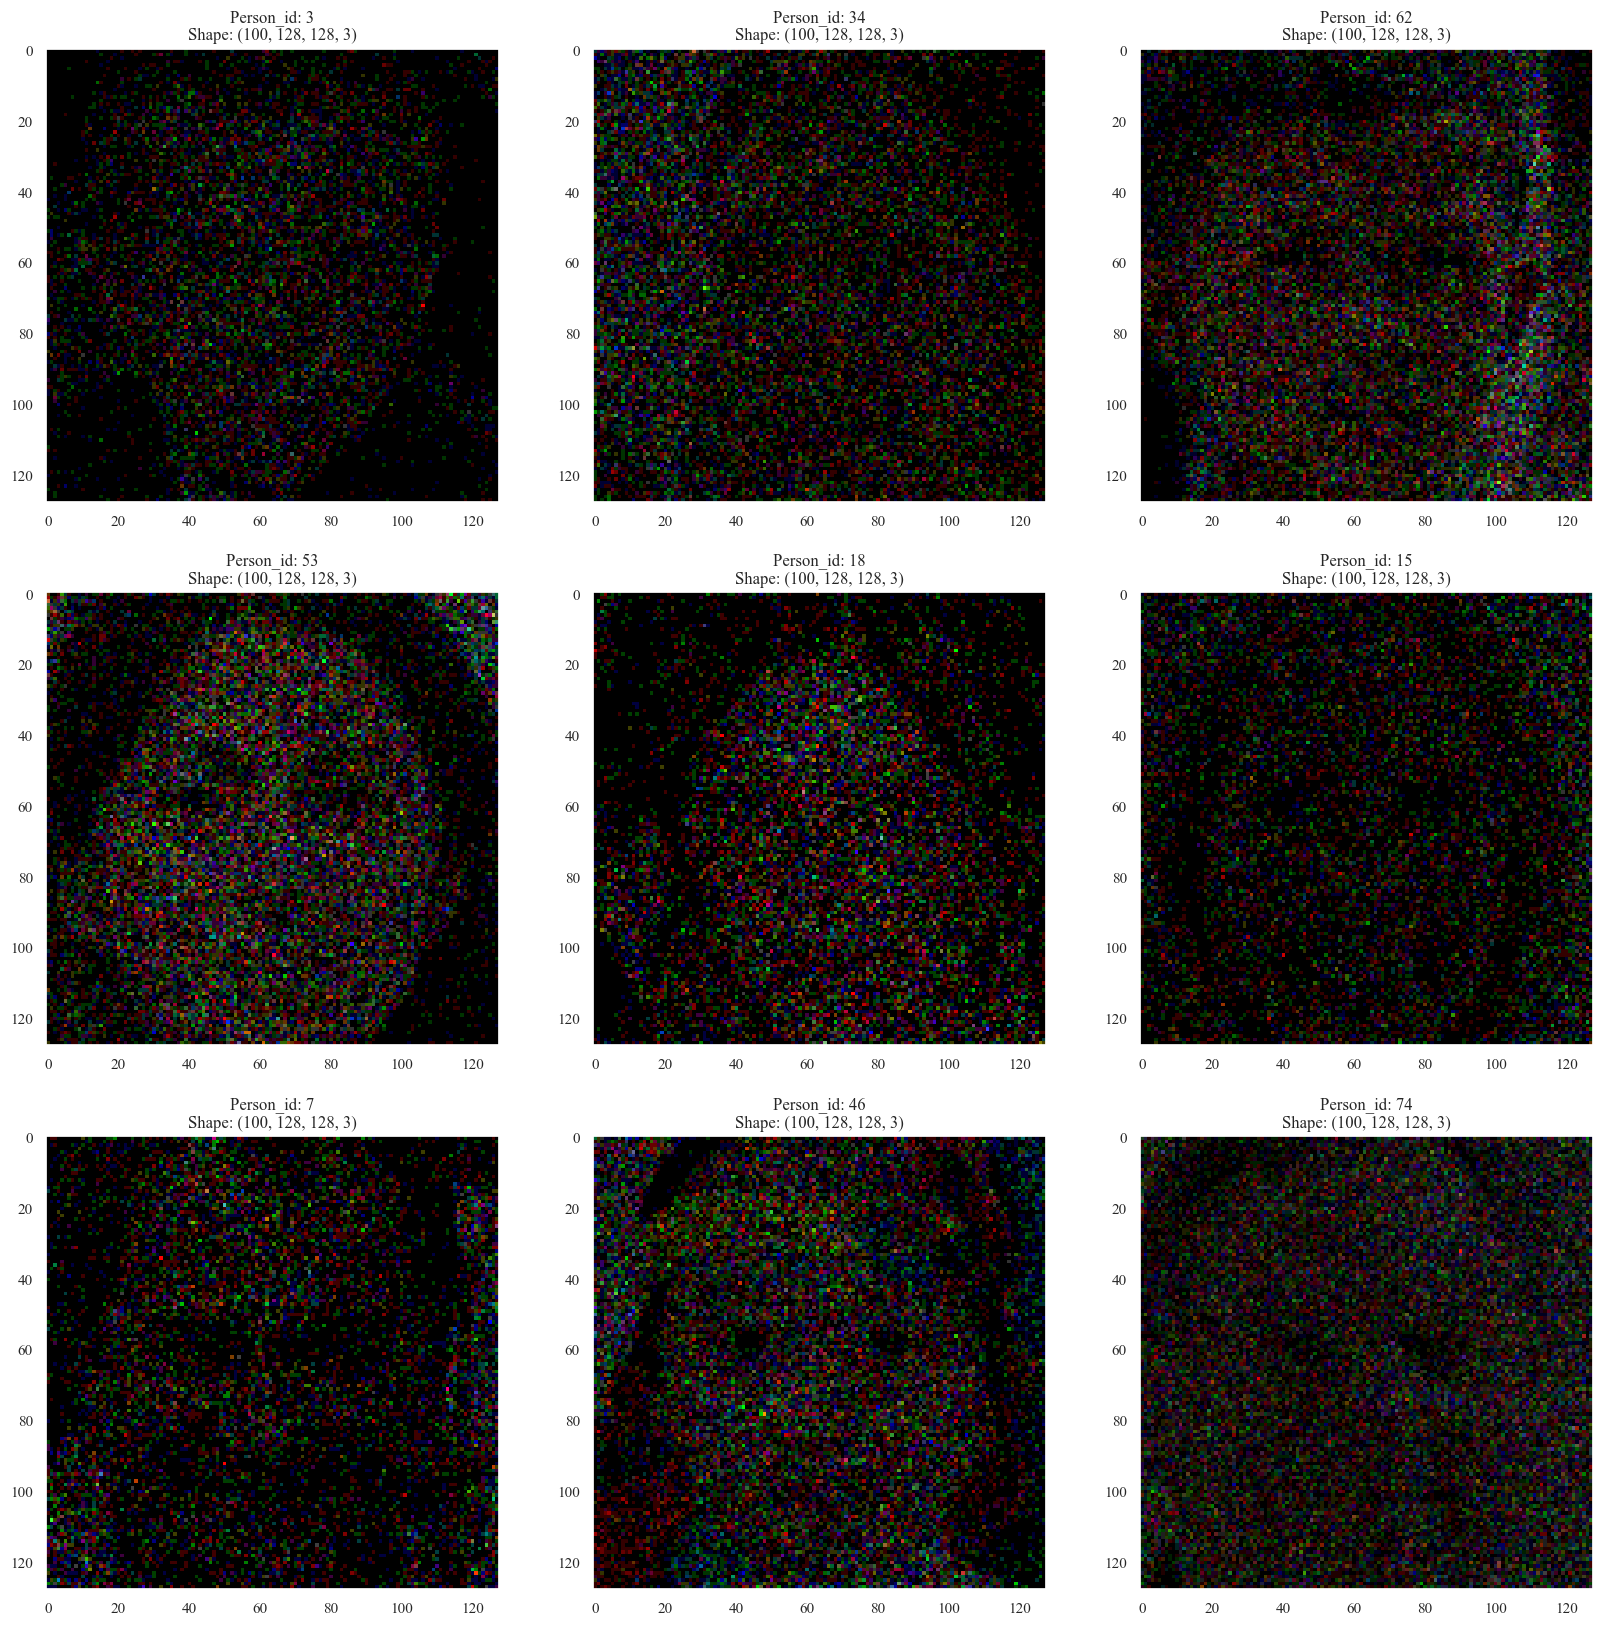

In [29]:
Figure_5 = plot_random_person(Validation_Noisy_Images["-80"].detach().cpu().numpy().transpose(0,2,3,1), 9)

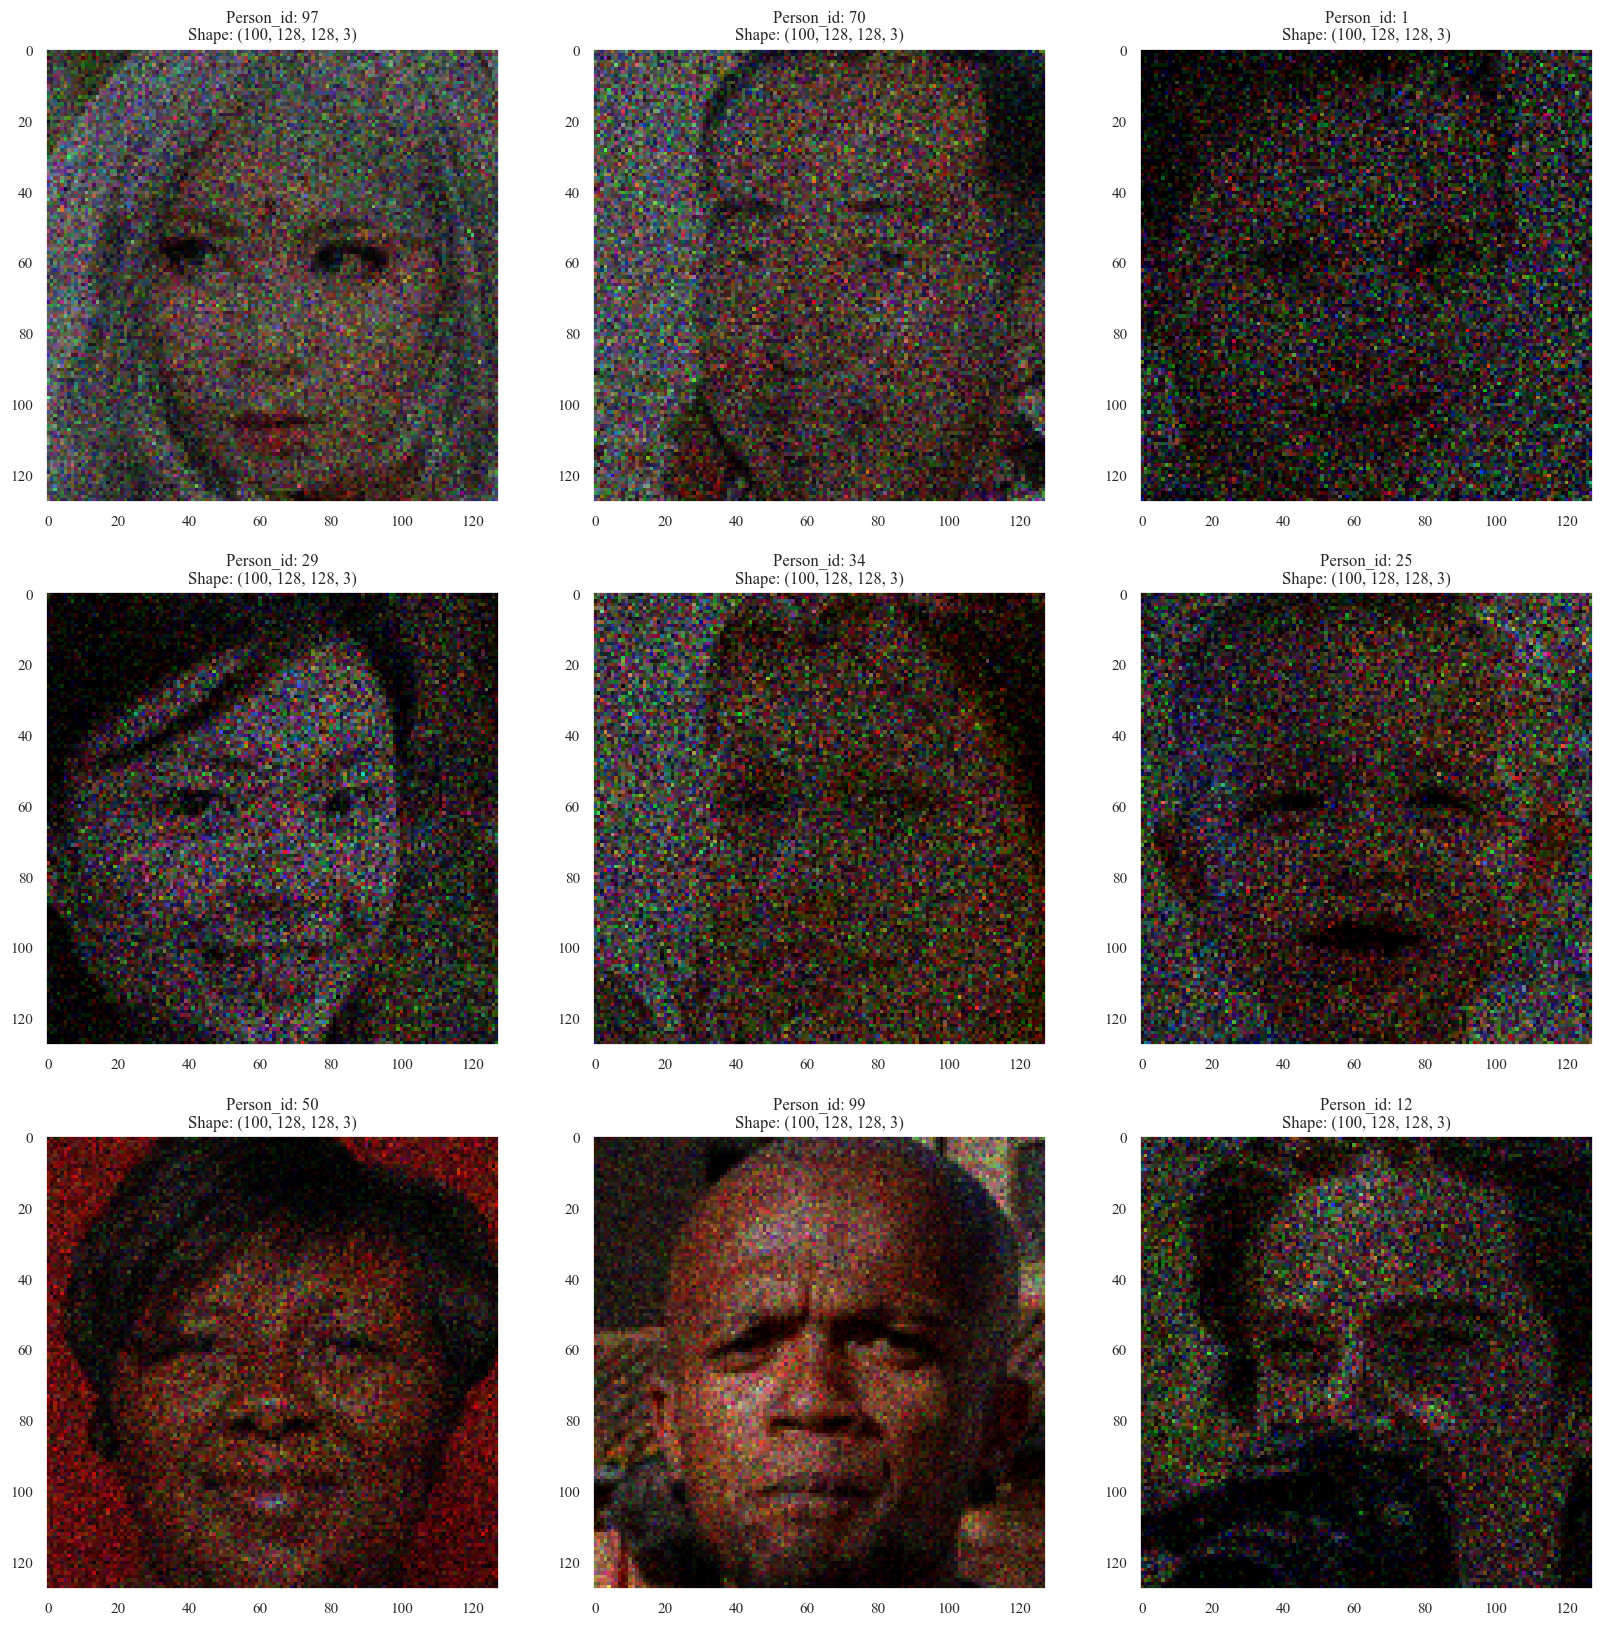

In [30]:
Figure_6 = plot_random_person(Validation_Noisy_Images["08"].detach().cpu().numpy().transpose(0,2,3,1), 9)

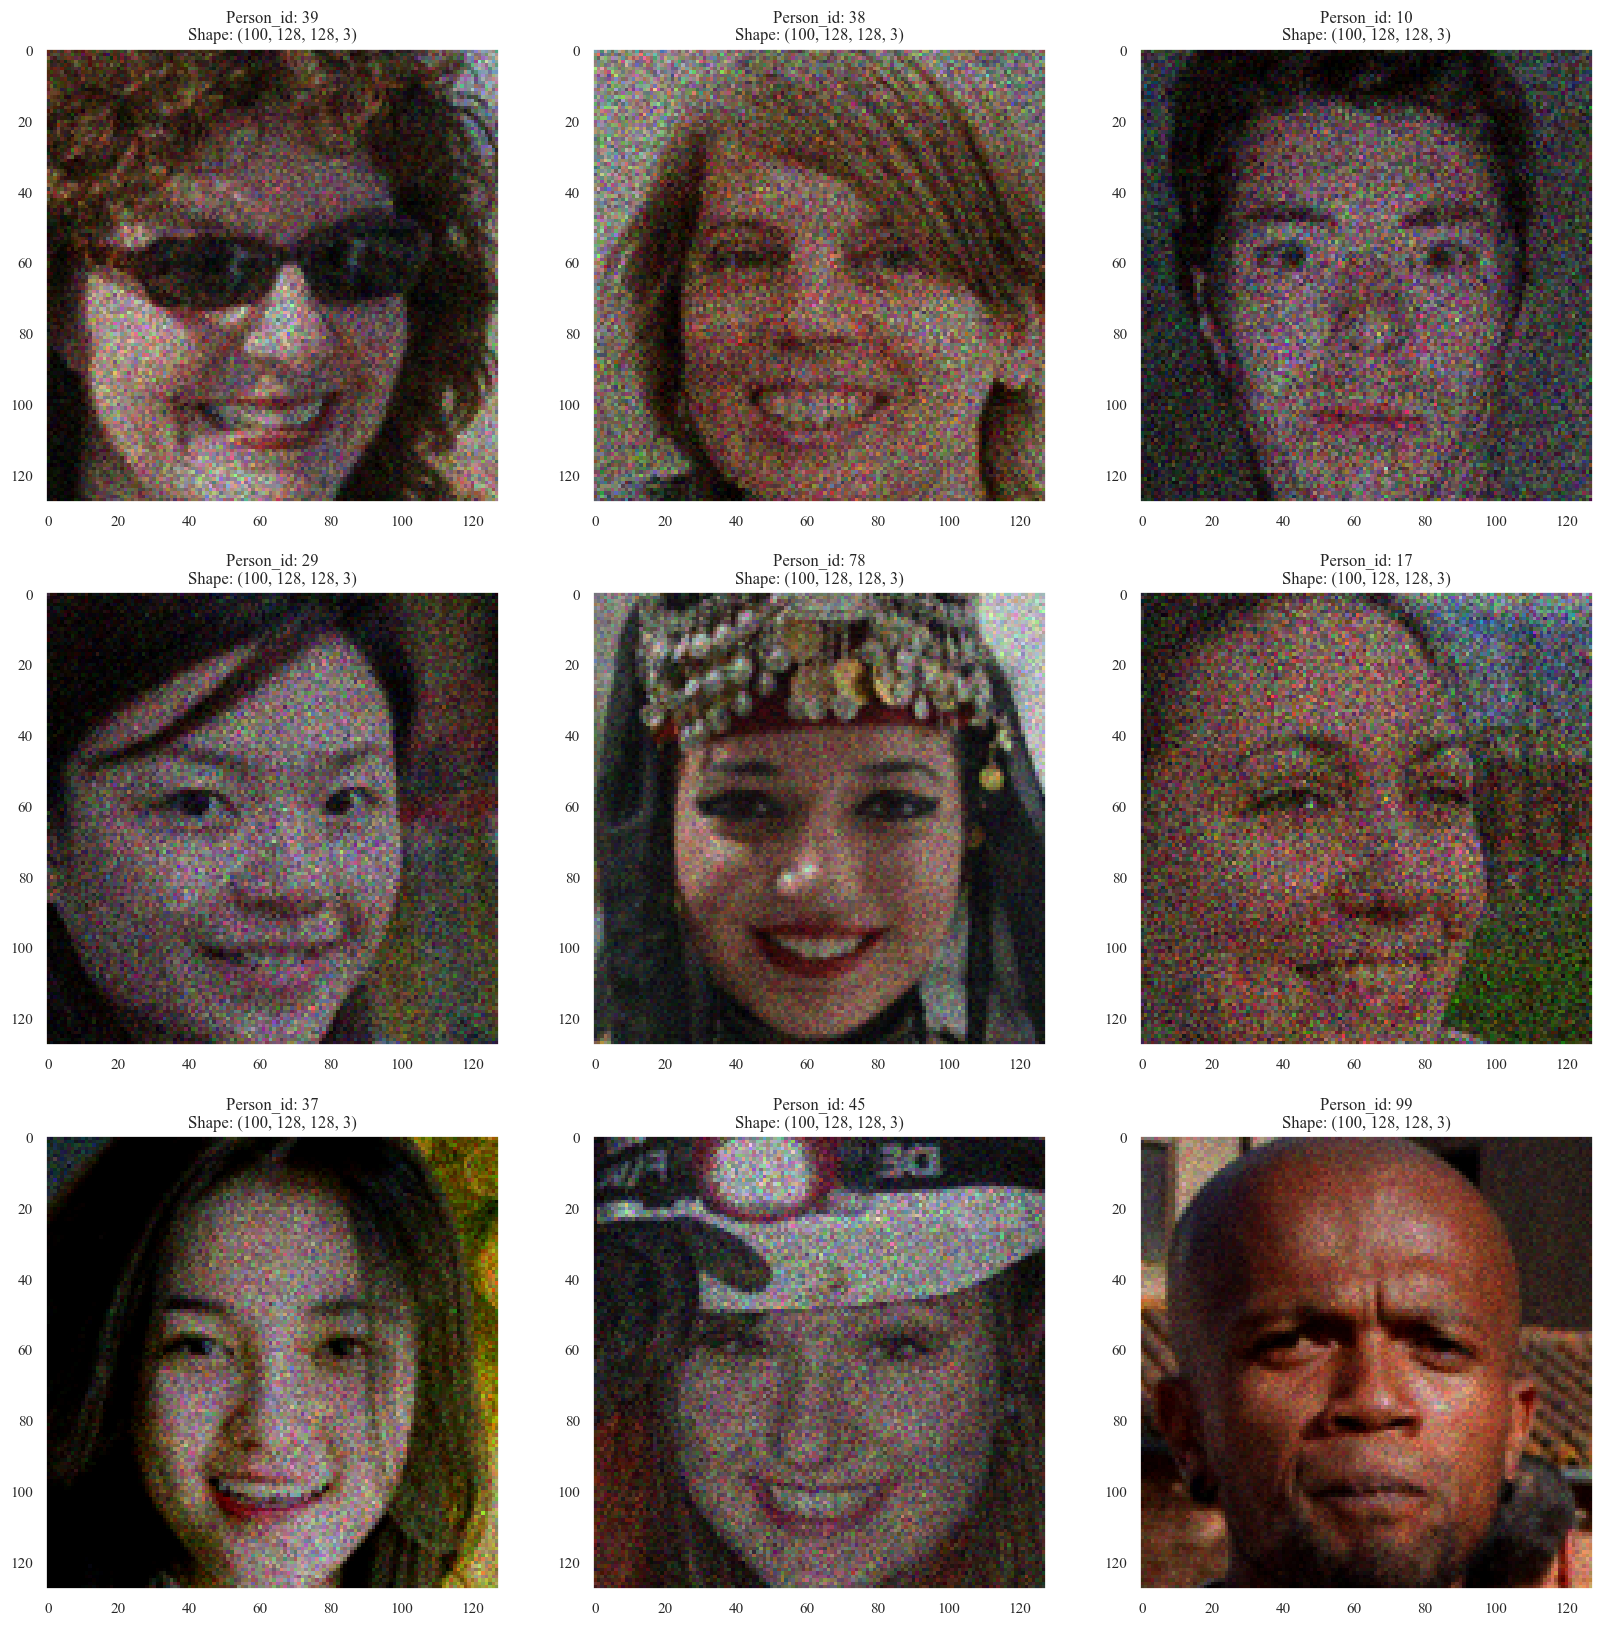

In [31]:
Figure_7 = plot_random_person(Validation_Noisy_Images["816"].detach().cpu().numpy().transpose(0,2,3,1), 9)

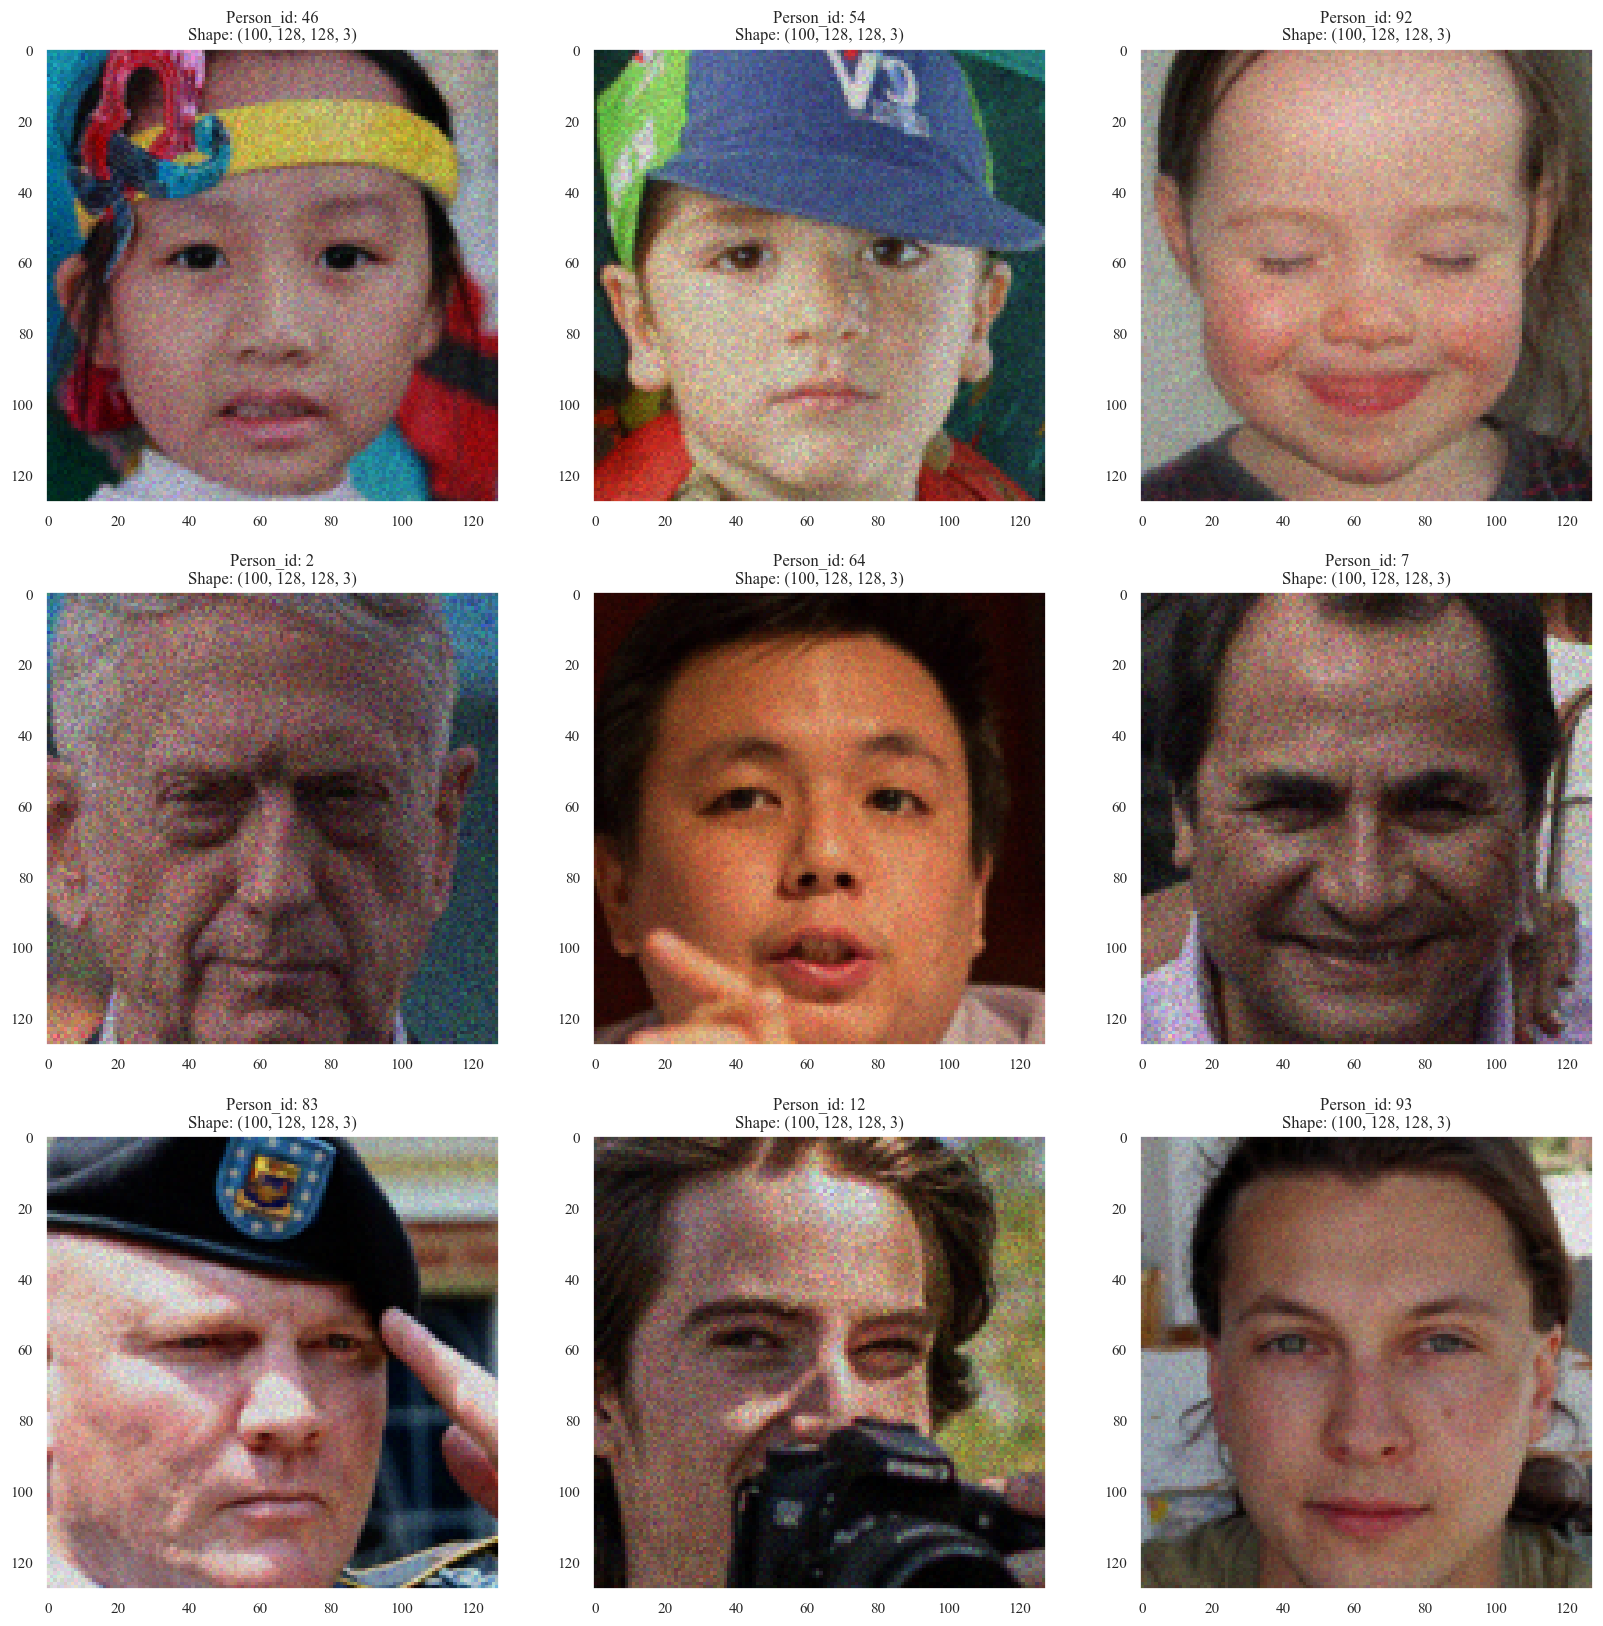

In [32]:
Figure_8 = plot_random_person(Validation_Noisy_Images["1624"].detach().cpu().numpy().transpose(0,2,3,1), 9)

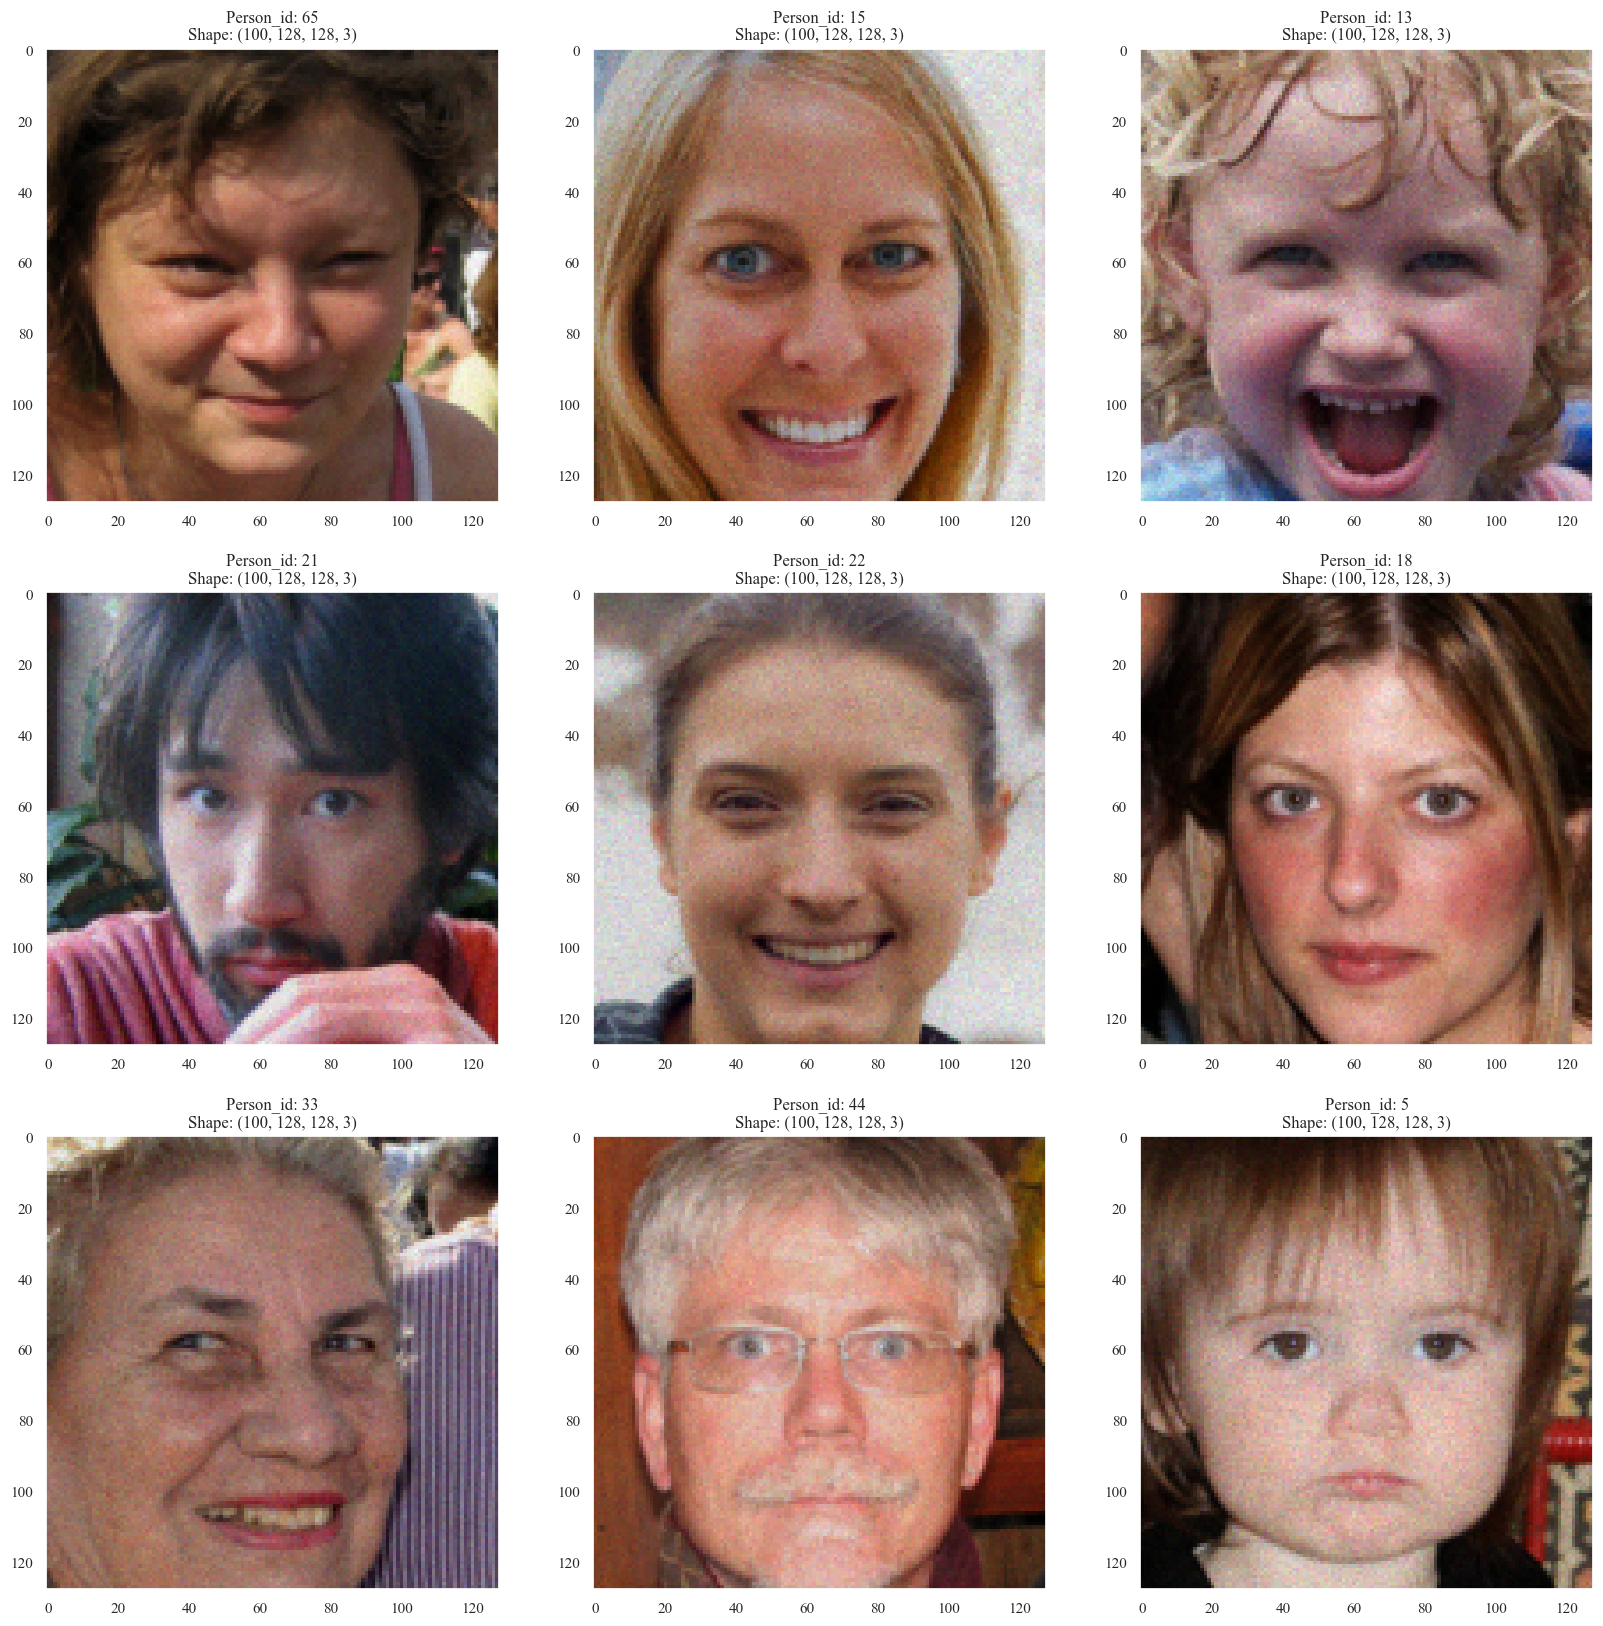

In [33]:
Figure_9 = plot_random_person(Validation_Noisy_Images["2432"].detach().cpu().numpy().transpose(0,2,3,1), 9)

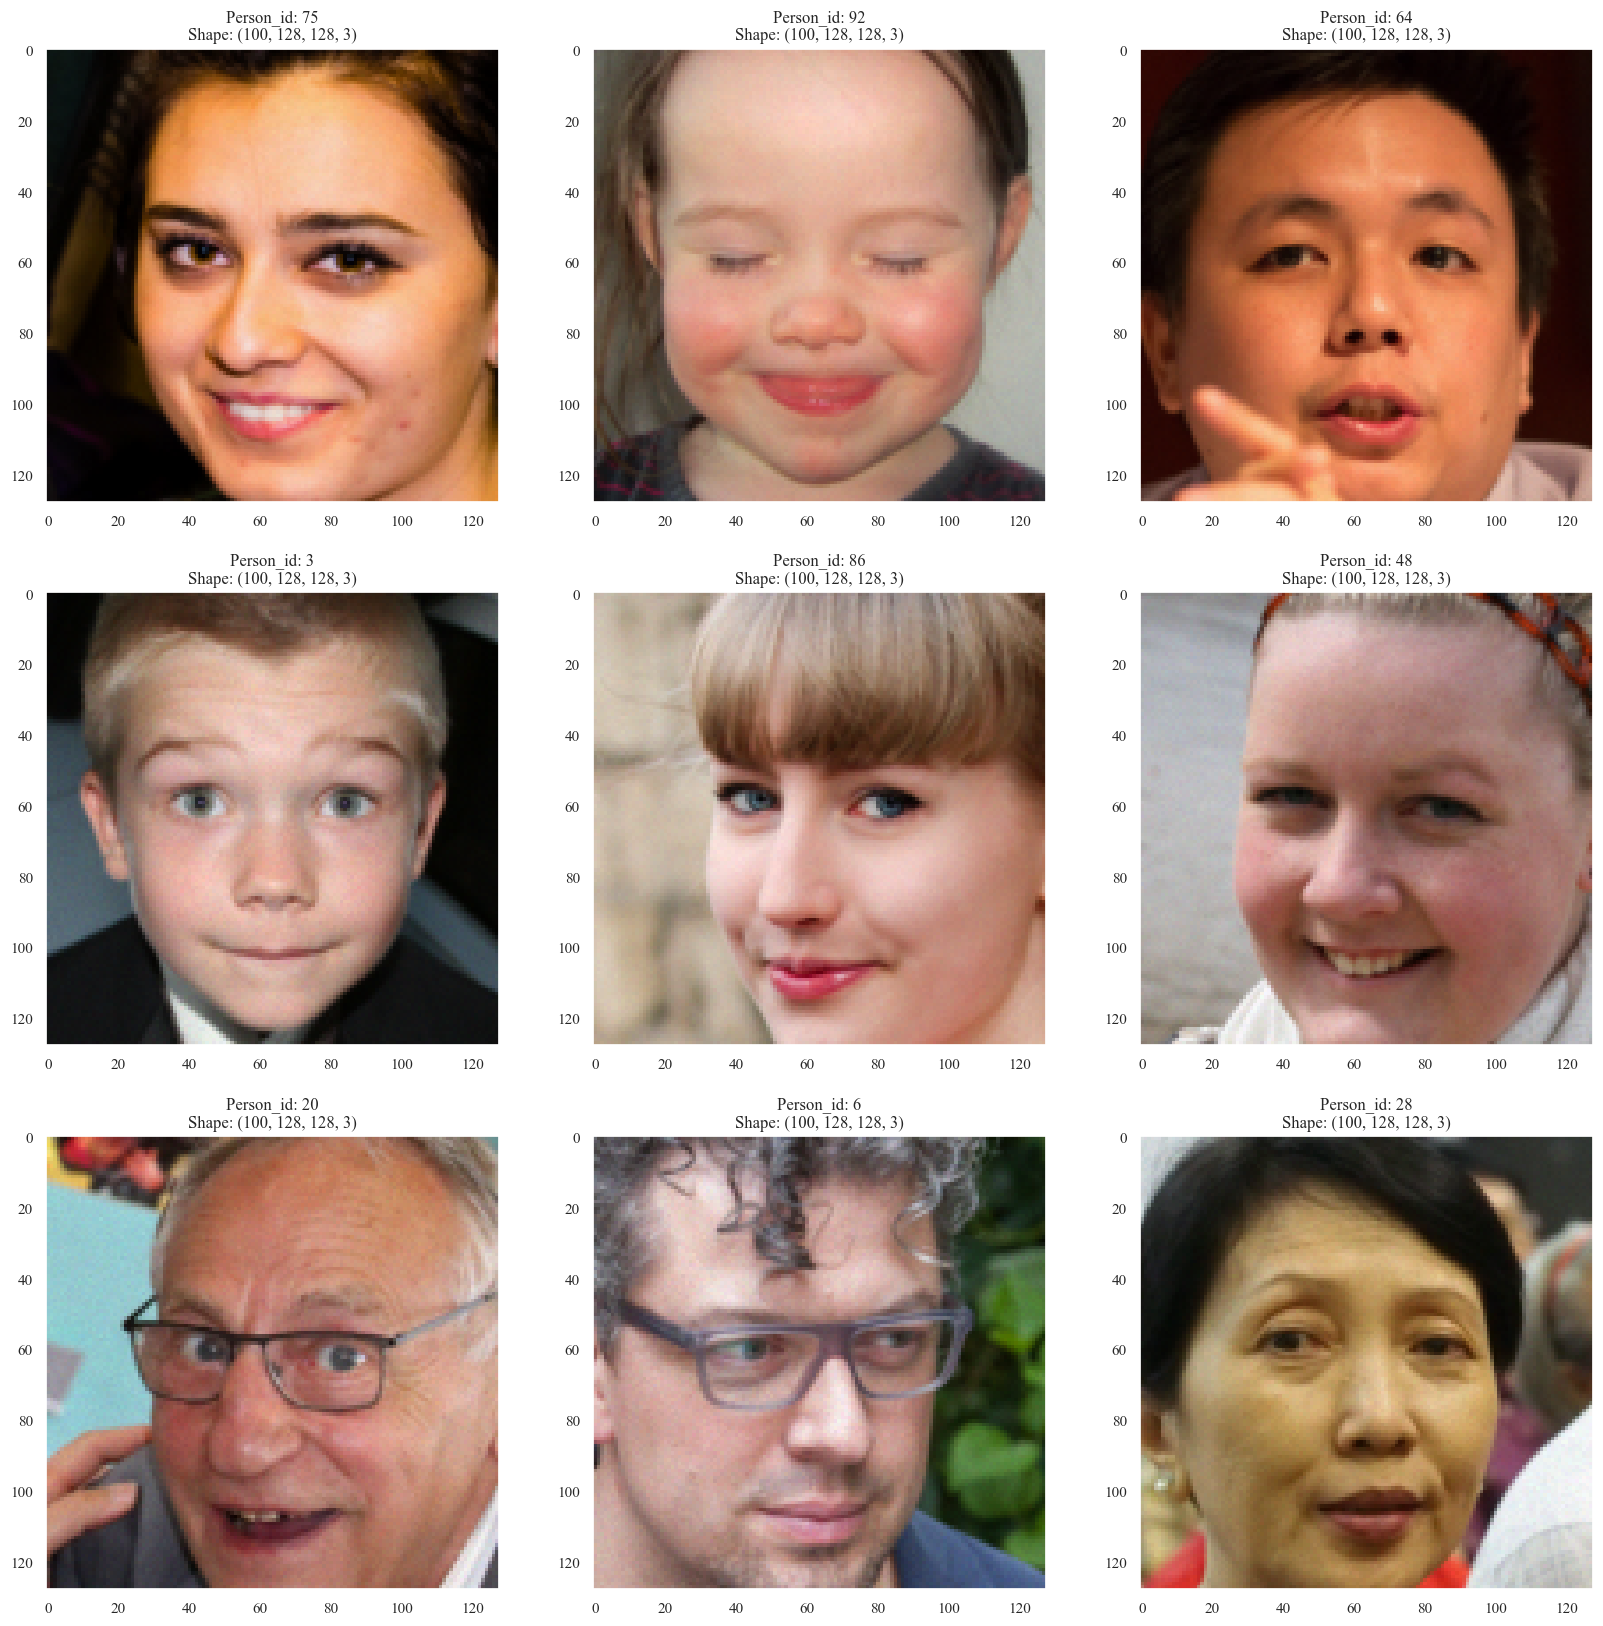

: 

In [34]:
Figure_9 = plot_random_person(Validation_Noisy_Images["3240"].detach().cpu().numpy().transpose(0,2,3,1), 9)